In [101]:
import pandas as pd
import numpy as np
import itertools
import snf
import networkx as nx
import pickle
from palettable import wesanderson
import sys
sys.path.insert(0 , './../MAIN/')
from utils import *
import preprocess_functions

In [102]:
modalities = ['mRNA'  ,'RPPA' , 'miRNA' , 'DNAm' ]
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

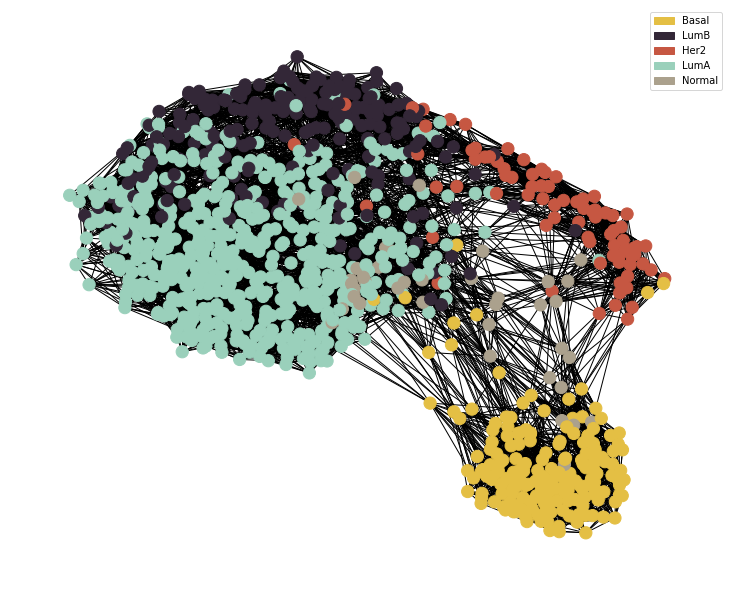

In [103]:
all_graphs = {}
all_idx = []
for i , mod in enumerate(modalities) : 
    with open(f'./../../data/raw/{mod}_processed.pkl', 'rb') as file:
        loaded_data = pickle.load(file)

    if i == 0 : 
        datMeta = loaded_data['datMeta'].reset_index()
    else : 
        datMeta = pd.merge(datMeta , loaded_data['datMeta'].reset_index() , how = 'outer'  , on = [index_col , target])

    all_graphs[mod] =  nx.read_graphml(f'./../../data/Networks/{mod}_graph.graphml')
    all_idx.extend(list(all_graphs[mod].nodes))
        
datMeta = datMeta.set_index(index_col)
all_idx = list(set(all_idx))

full_graphs = []

for mod , graph in all_graphs.items() : 
    full_graph = pd.DataFrame(data = np.zeros((len(all_idx) , len(all_idx))) , index=all_idx , columns=all_idx)
    graph = nx.to_pandas_adjacency(graph)
    full_graph.loc[graph.index , graph.index] = graph.values
    
    full_graphs.append(full_graph)

k = 15
#affinity_networks = snf.make_affinity(full_graphs, metric='euclidean', K=20, mu=0.5)
adj = snf.snf(full_graphs , K = k , t = 10)
np.fill_diagonal(adj , 1)

adj_snf = pd.DataFrame(data=adj , index=all_idx , columns=all_idx)

node_labels = pd.Series(adj_snf.index) 

node_colour = datMeta.loc[adj_snf.index][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

G  = preprocess_functions.plot_knn_network(adj_snf , k , datMeta.loc[adj_snf.index][target] ,
                                                       node_colours=node_colour , node_size=150)
snf_name = '_'.join(modalities)

nx.write_graphml(G, f'./../../data/Networks/{snf_name}_graph.graphml')